# **Analysis of RNA-seq expression dataset of pancreatic adenocarcinoma samples**

---

In [1]:
# @title Loading laundry list of required python modules

import numpy as np
#from sklearn import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import os
from collections import OrderedDict

from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif as mutual_info
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import pairwise_distances,f1_score
from sklearn.cluster import KMeans

import seaborn as sns; sns.set()

from google.colab import drive

%matplotlib inline

---
# 1) Loading data

Mounting google drive (if downloaded file is to be fetched from Drive folder):

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


### Reading in information from downloaded .gct file

The metadata and gene expression matrix are separately read into different Pandas tables, and the dataframes are transposed to bring the data into the format 'samples/patients' (in rows) x 'features' (in columns) (features are metadata entries and genes, respectively).

In [111]:
# Reading metadata and expression data separately from the tab-delimited text file to two Pandas dataframes. 
# Formatted as 'samples' (rows) X 'identifiers' (columns), consistent with general sklearn convention

df_meta = pd.read_csv('/content/drive/My Drive/Downloaded_Datasets/cancer_dataset.gct',sep='\t',skiprows=2,index_col=0,header=None,nrows=125).T

df_data = pd.read_csv('/content/drive/My Drive/Downloaded_Datasets/cancer_dataset.gct',sep='\t',skiprows=127,index_col=0,header=None).T

# Printing out shapes of the two dataframes:
print(df_meta.shape,df_data.shape)

(183, 125) (183, 18465)


---
# 2) Exploring the data

Viewing first few lines of the metadata: 

In [112]:
df_meta.head()

,id,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,age_at_initial_pathologic_diagnosis,alcohol_history_documented,alcoholic_exposure_category,amount_of_alcohol_consumption_per_day,anatomic_neoplasm_subdivision,anatomic_neoplasm_subdivision_other,b_symptoms,bcr,bcr_aliquot_uuid,bcr_canonical_reason-2,bcr_canonical_reason-3,bcr_canonical_reason,bcr_followup_barcode,bcr_followup_uuid,bcr_patient_canonical_status,clinical_m,clinical_n,clinical_stage,clinical_t,course_number,day_of_dcc_upload,day_of_form_completion,days_to_birth,days_to_diabetes_onset,days_to_index,days_to_initial_pathologic_diagnosis,days_to_pancreatitis_onset,days_to_psa,disease_code,...,person_neoplasm_cancer_status,prescribed_dose,prescribed_dose_units,primary_lymph_node_presentation_assessment,primary_pattern,primary_therapy_outcome_success,progression_determined_by-3,project_code,psa_value,race,radiation_therapy,radiation_type_notes,radiations,regimen_number,relative_cancer_type-2,relative_cancer_type,residual_tumor,route_of_administration,secondary_pattern,serum_markers,source_of_patient_death_reason,stopped_smoking_year,surgery_performed_type,system_version,targeted_molecular_therapy,tertiary_pattern,therapy_type_notes,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tobacco_smoking_history,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset
1,aab1-Primary solid Tumor,aab1,Primary solid Tumor,1,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66,NaN,NaN,yes,65,yes,weekly drinker,1,head of pancreas,NaN,NaN,nationwide children's hospital,d3f960b2-c69d-4b64-a30f-72f4fa7bb2f9,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-23962,NaN,0,0,NaN,NaN,paad,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,1988,whipple,7,yes,NaN,NaN,no,yes,2j,3,NaN,NaN,pancreas,primary,false,2016,2014,2012,1962
2,aab4-Primary solid Tumor,aab4,Primary solid Tumor,2,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729,NaN,yes,48,no,NaN,NaN,other (please specify),body & tail of pancreas,NaN,nationwide children's hospital,9daae9d7-747e-44e0-a8f8-3c3f9e3f03f3,NaN,NaN,NaN,tcga-2j-aab4-f62444,ce0b8128-82b9-4164-808f-1b4447134f54,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-17794,NaN,0,0,-292,NaN,paad,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,NaN,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,5,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN
3,aab6-Primary solid Tumor,aab6,Primary solid Tumor,3,tcga-2j-aab6,70797499-16e6-48cc-8ae4-1e692713dad3,dead,293,NaN,NaN,yes,75,no,NaN,NaN,body of pancreas,NaN,NaN,nationwide children's hospital,c850368e-6e95-4879-8245-205ddeec6fbd,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-27600,NaN,0,0,NaN,NaN,paad,...,with tumor,NaN,NaN,yes,NaN,progressive disease,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN
4,aab8-Primary solid Tumor,aab8,Primary solid Tumor,1,tcga-2j-aab8,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,alive,NaN,80,NaN,yes,71,no,NaN,NaN,head of pancreas,NaN,NaN,nationwide children's hospital,5749429c-5ac9-40de-b44e-3b795520ec07,NaN,NaN,NaN,tcga-2j-aab8-f62434,daf7d897-0ed7-48ec-ae70-080dd8d7d6bd,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-26028,NaN,0,0,NaN,NaN,paad,...,tumor free,NaN,NaN,yes,NaN,NaN,NaN,tcga,NaN,white,NaN,NaN,NaN,NaN,NaN,NaN,r1,NaN,NaN,NaN,NaN,NaN,whipple,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN
5,aab9-Primary solid Tumor,aab9,Primary solid Tumor,4,tcga-2j-aab9,a5748656-5330-417a-8938-01f69ddb3576,dead,62

Viewing first few lines of the expression data table:

In [113]:
df_data.head()

,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,...,ZP3,ZPBP2,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
1,6.4,4.7,-1.0,7.5,6.4,14.3,10.6,8.8,1.0,9.4,-1.0,10.2,9.2,4.8,10.2,9.6,11.8,NaN,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,1.8,7.4,1.0,7.8,10.4,9.7,1.0,8.1,7.9,9.3,6.9,...,7.7,NaN,3.9,9.4,9.4,5.5,8.1,4.0,7.2,6.9,9.1,1.5,6.0,8.0,7.3,3.4,8.7,7.1,0.5,6.0,0.5,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,NaN,9.2,12.9,10.1,9.3,5.5
2,5.8,5.7,1.1,6.8,NaN,14.0,10.2,5.6,-1.2,9.1,-0.2,10.3,5.0,6.3,10.4,9.8,11.4,0.3,8.4,8.7,11.6,9.0,7.5,8.2,10.2,8.1,9.3,4.9,5.7,6.3,4.9,3.0,8.5,10.9,9.5,0.8,9.0,6.0,9.7,6.7,...,6.6,NaN,5.7,9.6,10.2,5.4,7.9,5.0,7.0,6.1,9.8,3.1,6.0,7.6,6.2,3.7,8.5,7.5,-1.2,5.7,0.8,7.9,6.2,9.2,6.9,9.4,8.1,7.5,8.7,8.1,8.8,5.8,8.5,10.0,NaN,9.3,12.4,9.8,8.9,4.5
3,6.4,3.0,NaN,7.3,10.8,13.1,10.1,0.2,0.2,9.7,NaN,9.2,2.8,5.9,9.9,9.8,11.1,2.2,8.4,8.8,11.4,9.3,6.7,7.3,10.3,7.3,8.4,4.7,6.1,7.4,8.0,1.8,9.2,10.6,8.0,4.1,7.7,5.7,10.4,6.9,...,7.8,NaN,3.0,9.5,10.4,4.9,7.8,5.2,6.6,5.4,9.9,2.9,6.3,7.7,6.6,2.4,7.9,6.9,2.0,5.7,0.8,8.2,5.7,8.8,5.3,8.7,7.3,7.0,8.8,8.4,9.1,3.9,8.1,10.0,-0.8,9.4,13.5,9.8,9.2,4.7
4,5.8,5.1,NaN,7.5,4.1,13.8,8.6,3.2,-0.1,9.6,-0.1,9.4,7.7,6.4,10.5,9.2,11.6,-0.1,8.7,9.1,11.4,9.4,7.7,7.8,10.1,8.3,8.4,5.4,6.6,7.3,7.1,NaN,9.0,10.0,7.9,5.2,7.6,6.7,10.4,7.7,...,6.6,NaN,0.9,9.7,10.6,5.7,8.0,6.0,7.6,6.5,9.2,0.9,5.9,7.1,6.8,4.0,8.9,7.4,4.2,6.1,2.5,8.0,6.1,9.8,6.3,8.8,8.0,7.4,8.6,8.6,8.9,5.2,8.5,9.7,1.9,9.4,12.5,9.7,9.3,6.4
5,6.7,4.4,0.1,7.4,9.3,14.6,10.1,5.7,NaN,9.8,NaN,9.3,7.0,6.5,10.1,9.8,11.2,0.1,8.4,9.3,11.4,9.4,7.2,8.3,10.3,8.6,9.4,5.9,6.2,6.1,6.0,1.7,8.7,10.0,9.3,3.3,8.8,7.7,9.2,6.4,...,8.1,0.1,4.9,9.7,9.7,4.8,8.1,5.1,7.3,6.2,10.1,2.4,5.7,7.9,7.0,4.3,8.6,8.0,1.7,6.1,0.1,8.4,7.0,9.9,6.9,8.6,8.0,7.0,8.9,8.2,8.4,5.9,8.6,9.9,0.1,9.3,13.0,10.1,9.2,4.9


Several entries in either table are NaN/NA values. To begin with, all genes with 'NaN' entries across at least one sample are removed from the df_data table:

In [114]:
# @title Dropping gene columns with NaN entries
# Dropping probes/genes in expression data which are associated with 'NaN' values across 1 or more samples: 

df_data.dropna(axis='columns',inplace=True)

print(df_data.shape)

(183, 14098)


~20% of gene identifiers get filtered at this step. Next, we visualize the global expression profile as a heatmap (one sample per row):

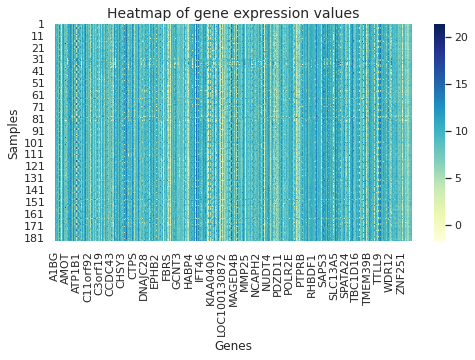

In [115]:
# Reading expression table to a numpy array, for later use/manipulation:
ExpMat = df_data.to_numpy()

# Visualizing global expression data as a heatmap:
fig, ax = plt.subplots(figsize=(8,4))

ax = sns.heatmap(df_data,linewidths=0.0,cmap="YlGnBu",xticklabels='auto',yticklabels='auto')

plt.xlabel('Genes')
plt.ylabel('Samples')
plt.title('Heatmap of gene expression values',size=14)

plt.show()

Note that the gene labels along the x-axis above have been sampled at uniform intervals from the full (~14000 genes-long) list.

A quick summarization of the data to check for normalization of gene expr profiles across samples:

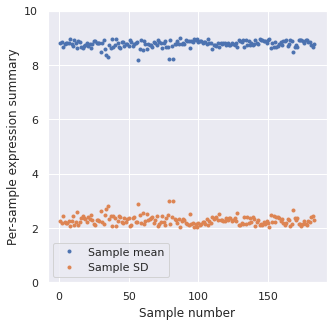

In [116]:
## Summary stats to check if expression matrix is normalized across samples:

sample_wise_mean = df_data.mean(axis=1)
sample_wise_sd = df_data.std(axis=1)

fig, ax = plt.subplots(figsize=(5, 5))

plt.plot(sample_wise_mean,'.',label='Sample mean')
plt.plot(sample_wise_sd,'.',label='Sample SD')

plt.ylim([0,10])
plt.xlabel('Sample number')
plt.ylabel('Per-sample expression summary')
plt.legend(loc='best')

plt.show()

---
## Dimensionality reduction

The high-d nature of the expression data (n_genes >> n_samples) confounds attempts to directly glean meaningful information from it, or visualize its structure. 

An unsupervised technique may be used to reduce dimensionality of the gene space and tease out informative patterns in the sample distribution. To start with, **principal component analysis (PCA)** is tried out. Each gene expression column is first standardized (subtract mean and scale by st. dev.), and then the top N directions of maximum variance (PCs) in the high-d gene space are extracted.

**PCA on gene expression matrix:**

(183, 100)


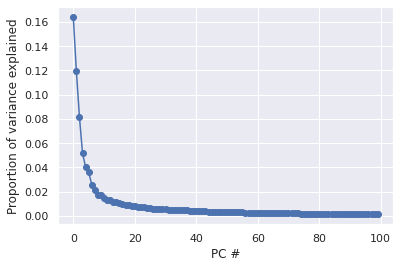

In [117]:
# Standardizing the data matrix (zero mean, unit SD per gene feature/column)
data_scaled = StandardScaler().fit_transform(df_data)

# Performing PCA on standardized data array
pca = PCA(n_components=100).fit(data_scaled)
expr_PC = pca.transform(data_scaled)

print(expr_PC.shape)  # Data projected on PC axes has dimensions 'no. of samples x n_components'

# Plotting proportion of variance explained by top PCs:
plt.plot(pca.explained_variance_ratio_,'o-')
plt.xlabel('PC #')
plt.ylabel('Proportion of variance explained')
plt.show()

Relative to the total # of genes, the top few components do seem to capture significant variance in the data distribution. Here, the projection of the data points into the 3-d space spanned by the top 3 PCs is plotted: 

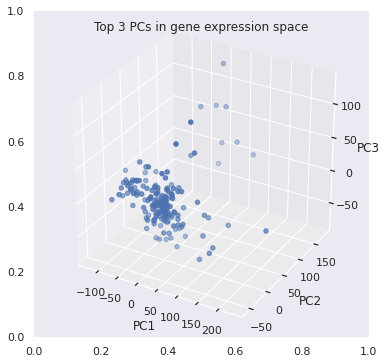

In [118]:
# @title Projecting data points onto top 3 PC axes

fig, ax = plt.subplots(figsize=(6, 6))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(expr_PC[:,0],expr_PC[:,1],expr_PC[:,2])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title("Top 3 PCs in gene expression space")

plt.show()

This view is not so clear, so replotting as a set of 2D scatter plots:

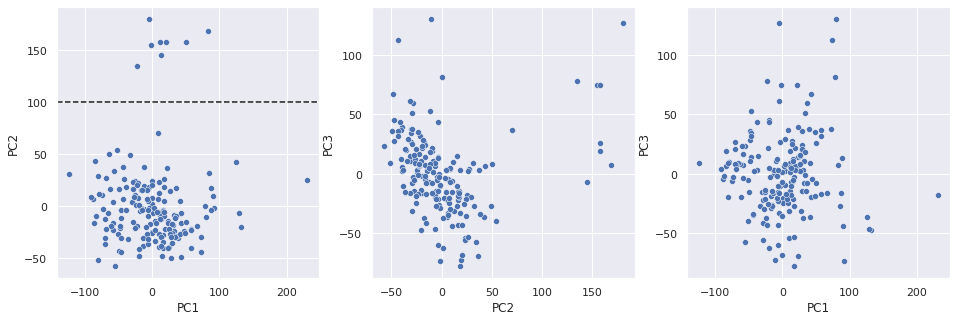

In [119]:
# Replotting as a set of 2D plots:

fig, ax = plt.subplots(figsize=(16, 5))

plt.subplot(1,3,1)
sns.scatterplot(x=expr_PC[:,0],y=expr_PC[:,1],data=expr_PC)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(100,color='k', linestyle='--')

plt.subplot(1,3,2)
sns.scatterplot(x=expr_PC[:,1],y=expr_PC[:,2],data=expr_PC);
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1,3,3)
sns.scatterplot(x=expr_PC[:,0],y=expr_PC[:,2],data=expr_PC);
plt.xlabel('PC1')
plt.ylabel('PC3')

plt.show()

Visually, a small subset of 8 data points appears to break off from a dominant group along the 2nd PC axis (PC2); a line perpendicular to the PC2 axis clearly segregates the two groups.

To ascertain if this split can be captured in an unguided manner, we apply k-means algorithm to the high-d expression table (full matrix, not in PC space), looking for two clusters.


### Finding clusters in the expression dataset using k-means method

In [120]:
# k-means with n=2 clusters sought:
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_data)

cluster_num = kmeans.labels_
km_clusters = list(set(cluster_num))

# Printing out array of cluster assignments for each sample:
print(cluster_num)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


The projection in 2D PC space is replotted, with data points colored according to the cluster labels above:

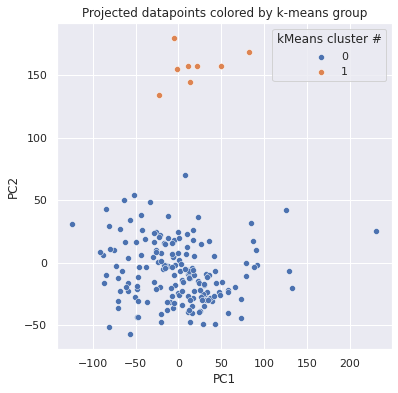

In [121]:
fig, ax = plt.subplots(figsize=(6, 6))

for cls in km_clusters: sns.scatterplot(x=expr_PC[cluster_num==cls,0],y=expr_PC[cluster_num==cls,1], label=cls)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best',title='kMeans cluster #')

plt.title('Projected datapoints colored by k-means group')

plt.show()

Somewhat expectedly, the detached small group pops out as cluster 1.

As a sanity check, it also helps to confirm existence of clusters in real-world data with different methods. Unlike the k-means method where no. of clusters is a parameter, the *Louvain method* infers the best split (# of clusters) based on a greedy modularity maximization algorithm. This method is implemented in the [community/NetworkX](https://python-louvain.readthedocs.io/en/latest/) modules, which are first imported:

In [122]:
import networkx as nx
from community import community_louvain

### Finding clusters in the expression dataset using Louvain modularity maximization

The algo takes the pairwise euclidean distances in gene space between all samples, and finds the optimal partition (groups) based on the distance matrix:

In [143]:
dist_matrix = pairwise_distances(df_data,metric='euclidean')

print(dist_matrix.shape)

# Converting distances to scaled graph weights (closer points = larger weights):
G = nx.from_numpy_matrix(1.0 - dist_matrix/np.amax(dist_matrix))
G.remove_edges_from(nx.selfloop_edges(G))

# Applying louvain community detection method:
partition = community_louvain.best_partition(G, weight='weight')
louvain_clusters = list(set(partition.values()))
cluster_labels = np.array(list(partition.values()))

print(cluster_labels)

(183, 183)
[2 2 2 2 0 2 2 0 2 2 2 2 0 0 0 2 2 2 2 2 2 2 1 2 0 2 2 2 2 1 1 1 1 1 1 2 1
 0 2 2 0 2 2 1 0 0 2 0 0 2 0 0 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 0 2 0 0 2 0 2
 2 0 2 2 2 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 2 2 0 0 2 2 2
 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 2 0 2 2 2 2 0 2 2 0 0 0 0 0
 2 0 0 2 2 2 0 2 2 2 0 2 2 0 0 2 2 0 0 2 2 2 2 0 0 0 0 2 0 0 0 0 2 2 0]


3 clusters are predicted by this method. To compare this split with the result from k-means, the 2D projection on top 2 PCs is replotted with colors as per the louvain communities:

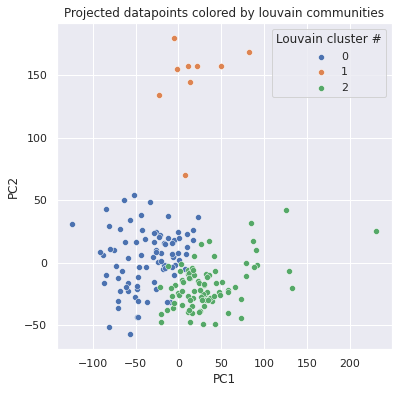

In [144]:
fig, ax = plt.subplots(figsize=(6, 6))

for cls in louvain_clusters: sns.scatterplot(x=expr_PC[cluster_labels==cls,0],y=expr_PC[cluster_labels==cls,1], label=cls)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='best',title='Louvain cluster #')
plt.title('Projected datapoints colored by louvain communities')

plt.show()

This is in agreement with the k-means split for the smaller group (except for one additional point at ~(0,70)), but further partitions the dominant group as well. Relevance of this split along the PC1 direction is not explored for now.

**Aside:** The above skewed distribution of data points also shows up in a nonlinear 2D embedding (here the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=t%20sne#sklearn.manifold.TSNE) implementation of *t-SNE* as an example):

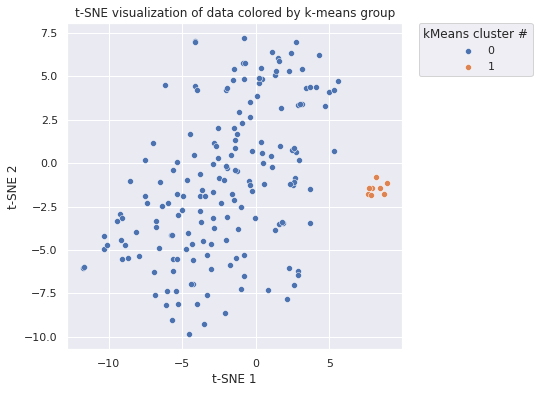

In [125]:
X_tsne = TSNE(n_components=2,random_state=42).fit_transform(ExpMat)

fig, ax = plt.subplots(figsize=(6, 6))

for cls in km_clusters: sns.scatterplot(x=X_tsne[cluster_num==cls,0],y=X_tsne[cluster_num==cls,1], label=cls)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='kMeans cluster #',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('t-SNE visualization of data colored by k-means group')

plt.show()

---
## Associating groups with metadata features

Based on concordance among visualized PC projection (clear segregation along PC2) and results of the clustering methods, two groups with disparate sizes (smaller group with 8 data points) are identified. To better understand this smaller subgroup, the metadata entries are examined for correspondence with these sample groupings.

A 'group' column is added to the metadata table, with row entries being the cluster labels predicted by k-means (smaller group = 1):



In [126]:
df_meta['group'] = cluster_num

df_meta.head()

,id,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,age_at_initial_pathologic_diagnosis,alcohol_history_documented,alcoholic_exposure_category,amount_of_alcohol_consumption_per_day,anatomic_neoplasm_subdivision,anatomic_neoplasm_subdivision_other,b_symptoms,bcr,bcr_aliquot_uuid,bcr_canonical_reason-2,bcr_canonical_reason-3,bcr_canonical_reason,bcr_followup_barcode,bcr_followup_uuid,bcr_patient_canonical_status,clinical_m,clinical_n,clinical_stage,clinical_t,course_number,day_of_dcc_upload,day_of_form_completion,days_to_birth,days_to_diabetes_onset,days_to_index,days_to_initial_pathologic_diagnosis,days_to_pancreatitis_onset,days_to_psa,disease_code,...,prescribed_dose,prescribed_dose_units,primary_lymph_node_presentation_assessment,primary_pattern,primary_therapy_outcome_success,progression_determined_by-3,project_code,psa_value,race,radiation_therapy,radiation_type_notes,radiations,regimen_number,relative_cancer_type-2,relative_cancer_type,residual_tumor,route_of_administration,secondary_pattern,serum_markers,source_of_patient_death_reason,stopped_smoking_year,surgery_performed_type,system_version,targeted_molecular_therapy,tertiary_pattern,therapy_type_notes,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tobacco_smoking_history,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset,group
1,aab1-Primary solid Tumor,aab1,Primary solid Tumor,1,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66,NaN,NaN,yes,65,yes,weekly drinker,1,head of pancreas,NaN,NaN,nationwide children's hospital,d3f960b2-c69d-4b64-a30f-72f4fa7bb2f9,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-23962,NaN,0,0,NaN,NaN,paad,...,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,1988,whipple,7,yes,NaN,NaN,no,yes,2j,3,NaN,NaN,pancreas,primary,false,2016,2014,2012,1962,0
2,aab4-Primary solid Tumor,aab4,Primary solid Tumor,2,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729,NaN,yes,48,no,NaN,NaN,other (please specify),body & tail of pancreas,NaN,nationwide children's hospital,9daae9d7-747e-44e0-a8f8-3c3f9e3f03f3,NaN,NaN,NaN,tcga-2j-aab4-f62444,ce0b8128-82b9-4164-808f-1b4447134f54,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-17794,NaN,0,0,-292,NaN,paad,...,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,NaN,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,5,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN,0
3,aab6-Primary solid Tumor,aab6,Primary solid Tumor,3,tcga-2j-aab6,70797499-16e6-48cc-8ae4-1e692713dad3,dead,293,NaN,NaN,yes,75,no,NaN,NaN,body of pancreas,NaN,NaN,nationwide children's hospital,c850368e-6e95-4879-8245-205ddeec6fbd,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-27600,NaN,0,0,NaN,NaN,paad,...,NaN,NaN,yes,NaN,progressive disease,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN,0
4,aab8-Primary solid Tumor,aab8,Primary solid Tumor,1,tcga-2j-aab8,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,alive,NaN,80,NaN,yes,71,no,NaN,NaN,head of pancreas,NaN,NaN,nationwide children's hospital,5749429c-5ac9-40de-b44e-3b795520ec07,NaN,NaN,NaN,tcga-2j-aab8-f62434,daf7d897-0ed7-48ec-ae70-080dd8d7d6bd,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-26028,NaN,0,0,NaN,NaN,paad,...,NaN,NaN,yes,NaN,NaN,NaN,tcga,NaN,white,NaN,NaN,NaN,NaN,NaN,NaN,r1,NaN,NaN,NaN,NaN,NaN,whipple,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,pancreas,primary,false,2016,2014,2012,NaN,0
5,aab9-Primary solid Tumor,aab9,Primary solid Tumor,4,tcga-2j-aab9,a5748656-5330-417a-8938-01f69ddb3576,dead,627,NaN,NaN,yes,70,yes,weekly drinker,1,head of pancreas,NaN,N

Basic eyeballing of the 125 metadata entries indicates that several of them only take on 'NA' values (these are ignored), and the rest are a mix of floats, integers, and text labels. To correlate these entries with the expression-based groups, we estimate the **mutual information** (MI) between each column (metadata feature) and the 'group' column in the metadata table. MI provides a general metric for quantifying statistical dependencies between discrete/continuous/categorical random variables.   

Defining some helper functions:

In [127]:
# Checks if string can be converted to float:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# Checks if string can be converted to an int:
def isint(value):
  try:
    int(value)
    return True
  except ValueError:
    return False

# Converting a string to an int/float where possible, otherwise leave it as-is:
def conv(x):
  if isint(x): return int(x)
  else:
    if isfloat(x): return float(x)
    else: return x


The following conventions are applied to uniformly estimate MI across all metadata types: 

(1) Only rows with non-NA values are retained;

(2) Metadata columns with all floats or all ints are identified;

(3) Columns with categorical entries are converted to ordinal (integer) values;

(4) The generic provided function in sklearn ([mutual_info_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)) is used for estimating MI between discrete target labels and discrete/continuous variables.


The following code snippet loops over all metadata columns to output a list of MI estimates (one value per feature, also displaying dtype and no. of valid entries per feature):

In [128]:
# Identifying the metadata identifiers with continuous values:
conti_features = ['amount_of_alcohol_consumption_per_day','frequency_of_alcohol_consumption','maximum_tumor_dimension','number_pack_years_smoked']

# Vector of all metadata identifiers:
meta_features = df_meta.columns[:-1]

mutual_info_list = []

# Looping over identifiers; categorical entries are encoded as ordinal values.
for m in meta_features:
  
  feature_group_pair = df_meta[[m,'group']].dropna() 

  if feature_group_pair.shape[0]>0:

    print(m,feature_group_pair.shape,end="  ")

    # Categorical entries identified:
    if np.any([(isfloat(f)==False) and (isint(f)==False) for f in feature_group_pair[m]]):
      
      categories = np.unique(feature_group_pair[m]).tolist()
      cat2ord = dict(zip(categories,range(len(categories))))  ## cat2ord is an alternative to OrdinalEncoder() function in sklearn and maps categorical entries to integers
      
      X = np.array([cat2ord[f] for f in feature_group_pair[m]])
      
      info = mutual_info(X.reshape(-1,1), feature_group_pair['group'], discrete_features=True, n_neighbors=3, copy=True)[0]
      print('categorical',info)
      mutual_info_list.append([m,info])
    
    else:
      X = np.array([conv(f) for f in feature_group_pair[m]])  ## strings are converted to ints/floats according to the identified data type

      ## The 'discrete_features' variable in MI function is set to indicate whether the corresponding metadata identifier takes discrete or continuous values 
      if m in conti_features: disc=False
      else: disc = True
      info = mutual_info(X.reshape(-1,1), feature_group_pair['group'], discrete_features=disc, n_neighbors=3, copy=True)[0]
      print('ordinal',info)
      mutual_info_list.append([m,info])

print(df_meta.shape,len(mutual_info_list))

id (183, 2)  categorical 0.17957862404331335
participant_id (183, 2)  categorical 0.17957862404331343
sample_type (183, 2)  categorical 0.0012387042618496984
mRNAseq_cluster (178, 2)  ordinal 0.0931905579046016
bcr_patient_barcode (183, 2)  categorical 0.17957862404331346
bcr_patient_uuid (183, 2)  categorical 0.17957862404331343
vital_status (183, 2)  categorical 0.03308694881526483
days_to_death (95, 2)  ordinal 0.0
days_to_last_followup (88, 2)  ordinal 0.3046360973492385
adenocarcinoma_invasion (183, 2)  categorical 0.00024494835364166287
age_at_initial_pathologic_diagnosis (183, 2)  ordinal 0.08564011690265298
alcohol_history_documented (171, 2)  categorical 1.2492084096413225e-05
alcoholic_exposure_category (102, 2)  categorical 0.0292388352469588
amount_of_alcohol_consumption_per_day (32, 2)  ordinal 0
anatomic_neoplasm_subdivision (183, 2)  categorical 0.02994840829985384
anatomic_neoplasm_subdivision_other (11, 2)  categorical 0.304636097349238
bcr (183, 2)  categorical 2.7755

Rearranging the metadata features in order of MI estimates (association with the group labels), and plotting the top-ranked features:

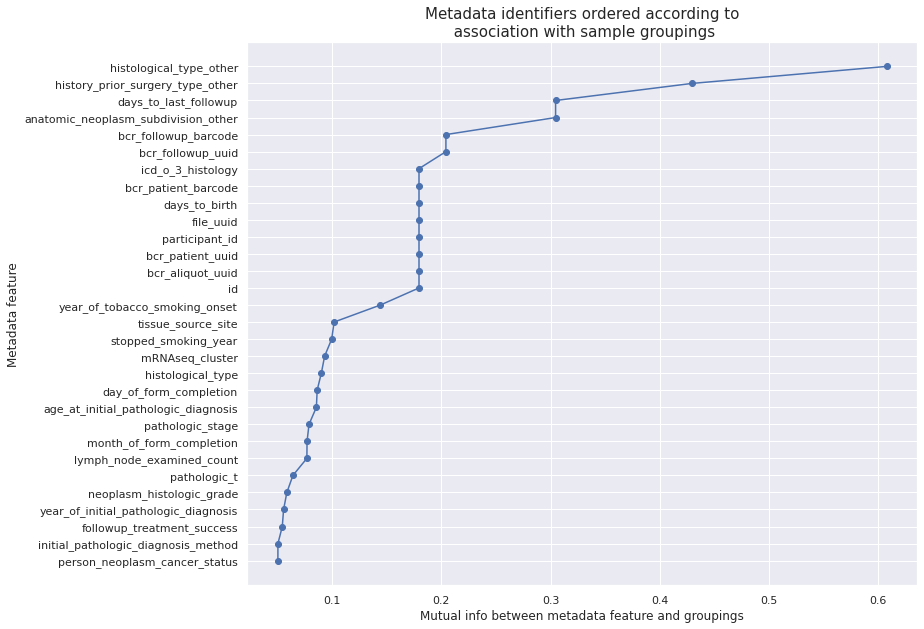

In [129]:
# Features sorted in decreasing order of MI with target/group labels:
mutual_info_list = sorted(mutual_info_list, key = lambda l: l[1],reverse=True)

features = [l[0] for l in mutual_info_list]
mi = [l[1] for l in mutual_info_list]

fig, ax = plt.subplots(figsize=(12, 10))

nMax = 30
plt.plot(mi[:nMax],range(1,1+nMax),'o-')
plt.yticks(range(1,1+nMax),features[:nMax])
ax.invert_yaxis()
plt.xlabel('Mutual info between metadata feature and groupings')
plt.ylabel('Metadata feature')
plt.title('Metadata identifiers ordered according to\n association with sample groupings',size=15)

plt.show()

Scanning through the metadata it's clear that a lot of features are irrelevant, and a large number of NA entries for some of the features makes ascertaining clear association (esp. with the smaller group) difficult. 

Among the top-ranked features, 'histological_type_other' (# 1) and 'icd_o_3_histology' show up. These are examined further, after first rearranging the metadata columns according to the order above: 

In [130]:
## Sorting metadata columns according to the association with the 'group' labels (above), 
## and reordering the rows/samples so that the smaller cluster (labeled '1') sits at the top. 

df_meta_sorted = df_meta[features+['group']].sort_values('group',ascending=False)

df_meta_sorted.head(10)

,histological_type_other,history_prior_surgery_type_other,days_to_last_followup,anatomic_neoplasm_subdivision_other,bcr_followup_barcode,bcr_followup_uuid,icd_o_3_histology,bcr_patient_barcode,days_to_birth,file_uuid,participant_id,bcr_patient_uuid,bcr_aliquot_uuid,id,year_of_tobacco_smoking_onset,tissue_source_site,stopped_smoking_year,mRNAseq_cluster,histological_type,day_of_form_completion,age_at_initial_pathologic_diagnosis,pathologic_stage,month_of_form_completion,lymph_node_examined_count,pathologic_t,neoplasm_histologic_grade,year_of_initial_pathologic_diagnosis,followup_treatment_success,initial_pathologic_diagnosis_method,person_neoplasm_cancer_status,icd_10,icd_o_3_site,number_of_lymphnodes_positive_by_he,targeted_molecular_therapy,pathologic_n,vital_status,surgery_performed_type,anatomic_neoplasm_subdivision,alcoholic_exposure_category,pathologic_m,...,residual_tumor,radiation_therapy,bcr_patient_canonical_status,history_of_diabetes,ethnicity,followup_case_report_form_submission_reason,sample_type,gender,adenocarcinoma_invasion,history_of_neoadjuvant_treatment,alcohol_history_documented,source_of_patient_death_reason,number_of_lymphnodes_positive_by_ihc,bcr,day_of_dcc_upload,disease_code,informed_consent_verified,month_of_dcc_upload,project_code,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,days_to_death,amount_of_alcohol_consumption_per_day,bcr_canonical_reason-2,bcr_canonical_reason-3,bcr_canonical_reason,days_to_diabetes_onset,days_to_pancreatitis_onset,frequency_of_alcohol_consumption,maximum_tumor_dimension,number_pack_years_smoked,progression_determined_by-3,relative_cancer_type-2,days_to_index,days_to_initial_pathologic_diagnosis,init_pathology_dx_method_other,patient_death_reason,group
30,neuroendocrine carcinoma nos,NaN,1854,NaN,tcga-3a-a9ij-f69254,0ff13a75-b02e-4f00-842a-b773296110d6,8246,tcga-3a-a9ij,-23791,5a3b47f9-afca-4b07-bba9-4f147271d9a3,a9ij,5f468c25-73c3-49d5-ba12-50653dfe2c41,476271da-e978-4a84-a747-991e8423487c,a9ij-Primary solid Tumor,1954,3a,1984,2,pancreas-adenocarcinoma-other subtype,31,65,stage ib,12,16,t2,g1,2009,complete remission/response,tissue biopsy,tumor free,c25.0,c25.0,0,no,n0,alive,whipple,head of pancreas,NaN,mx,...,r0,no,canonical,no,not hispanic or latino,scheduled follow-up submission,Primary solid Tumor,male,yes,no,no,NaN,0,nationwide children's hospital,21,paad,yes,1,tcga,pancreas,primary,false,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,25,NaN,NaN,0,0,NaN,NaN,1
23,neuroendocrine,NaN,1383,"panreatic body and tail, spread to stomach",tcga-2l-aaqm-f62942,3c75fc7a-be20-4d6c-a5f5-279673e01b4c,8246,tcga-2l-aaqm,-19315,775bf516-5bb9-4ac1-8b5d-0a20d046dadc,aaqm,7240d5da-b54e-436b-8069-f2c9f516b75e,f99fe51d-a1f6-4509-a45f-d4c78835fa0d,aaqm-Primary solid Tumor,NaN,2l,NaN,2,pancreas-adenocarcinoma-other subtype,29,52,stage iib,7,57,t3,g1,2010,complete remission/response,tumor resection,tumor free,c25.0,c25.0,16,no,n1,alive,distal pancreatectomy,other (please specify),daily drinker,mx,...,r1,no,canonical,NaN,NaN,scheduled follow-up submission,Primary solid Tumor,male,yes,no,yes,NaN,NaN,nationwide children's hospital,21,paad,yes,1,tcga,pancreas,primary,false,2016,NaN,4,NaN,NaN,NaN,NaN,NaN,7,14,NaN,NaN,NaN,0,0,NaN,NaN,1
31,neuroendocrine carcinoma nos,NaN,2741,NaN,tcga-3a-a9il-f69133,b2b2cbad-9251-4be9-94d0-084fcb81e398,8246,tcga-3a-a9il,-14599,2a329c8e-7391-4bcc-8c9c-d65430f43bae,a9il,24a40289-96fd-4c1a-a953-45a46a0a0e9d,b7947a48-2530-4e6a-b4bf-4a070b194de4,a9il-Primary solid Tumor,NaN,3a,NaN,2,pancreas-adenocarcinoma-other subtype,29,39,stage i,12,9,t1,g1,2007,NaN,tissue biopsy,tumor free,c25.1,c25.1,5,no,NaN,alive,whipple,head of pancreas,NaN,mx,...,r0,no,canonical,no,not hispanic or latino,scheduled follow-up submission,Primary solid Tumor,female,yes,no,no,NaN,0,nationwide children's hospital,21,paad,yes,1,tcga,pancreas,primary,false,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,0,0,NaN,NaN,1
32,neuroendocrine carcinoma nos,subtotal pancreatectomy,2084,NaN,tcga-3a-a9i

Group 1 seems to be associated with *neuroendocrine carcinoma nos* samples (1st and last cols above). Examining the 'icd_o_3_histology' entries, all 8 samples in this group are exclusively labeled '8246' which also corresponds to *Neuroendocrine carcinoma, NOS* (from e.g. https://cancercenter.ai/icd-o-pathology-codes/morphological-codes-icd-o-3/). The other entires represented in this column are:

8020: Carcinoma, undifferentiated, NOS

8140: Adenoma, NOS

8246: Neuroendocrine carcinoma, NOS

8255: Adenocarcinoma with mixed subtypes

8480: Low grade appendiceal mucinous neoplasm / Mucinous adenocarcinoma

8500: Infiltrating duct carcinoma

Coloring the PC subspace projections of the expression dataset according to the above metadata column labels:

List of unique features for this metadata entry:  8020 | 8140 | 8246 | 8255 | 8480 | 8500


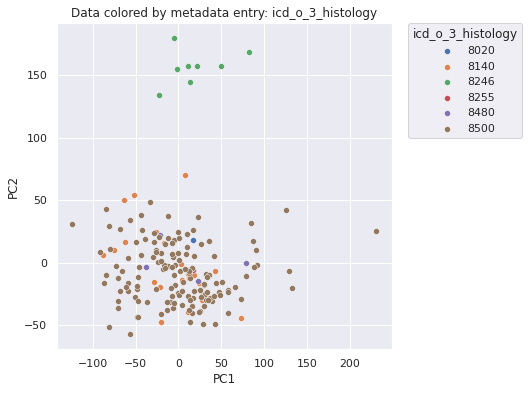

In [131]:
fName = 'icd_o_3_histology' #'histological_type_other'

featureVec = df_meta[fName].astype(str)
unique_features = [k for k in np.unique(featureVec) if k!='nan']
print('List of unique features for this metadata entry: ',' | '.join(unique_features))

fig, ax = plt.subplots(figsize=(6, 6))

for f in unique_features: sns.scatterplot(x=expr_PC[featureVec==f,0],y=expr_PC[featureVec==f,1], label=f)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title=fName,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Data colored by metadata entry: '+fName)

plt.show()

None of the points in the dominant group are assigned the '8246' identifier.

---

**Aside: Biological significance of expression differences**

To better understand the small group (subtype) highlighted above, the PC2 loadings on the original axes (genes) are examined. The top 100 genes maximally aligning with PC2 vector (by magnitude) are listed here (comment out the relevant line below):

In [132]:
pc2_vec = np.abs(pca.components_[1,:])
print(pc2_vec.shape)

pc2_gene_scores = np.array(sorted(zip(df_data.columns,pc2_vec.tolist()),reverse=True,key = lambda l: l[1]))

# Printing out top 100 genes maximally aligned with PC2:

# Comment out below line to print out the gene list
for g in pc2_gene_scores[:100,0]: print(g)

(14098,)
PLEK2
OSBPL3
LAMB3
COQ10A
VAMP2
MST1R
SLC26A11
RHBDL2
ANXA3
GPRC5A
LGALS3
FAM69B
CIRBP
TNFRSF10A
PDZD4
MET
C3orf52
C20orf132
ANXA2P2
LOC401431
S100A11
CYB5D2
IGF2BP2
MYOF
B3GNT1
LOC728392
QDPR
CEP55
TGFA
ANXA2
EID2B
PRRT3
ITGB4
SLC22A17
KLF5
HDHD2
LOC338758
LOC100303728
PTK6
LAMC2
SNPH
CAPG
TGIF1
TMC7
RHOF
SYP
EML5
INPP4B
RALB
RND2
KCNN4
MYO1E
ZNF540
EFNA4
HK2
LRRC8E
ANLN
LDHA
NEURL4
UHRF1
DPH1
CRTC1
USP27X
LRRC4B
ICA1L
DLGAP5
PRSS8
ECT2
CASP8
ATP6V0E2
PIPOX
ANKRD22
ITPR3
FAM117A
ITGA6
PDXP
FGD6
POMT1
MTMR7
YWHAZ
TMED8
MED9
PLBD1
S100A16
MAPK8IP1
SLC25A14
PELI3
FHL2
EPHA2
IQGAP3
CDH3
FXR2
SPTBN4
CACNA1A
SH2D4A
NAP1L5
PPP1R3F
HNRNPF
ACSL5
REEP2


This gene set maximally captures the expression differences between the group 1 subset and the rest of the samples. To relate this gene set to possible functional differences, databases of prior bio knowledge (e.g. precompiled TF regulatory networks or pathways) can be queried, shedding more light on the biological processes significantly associated with the aligned genes. 

As an example, the [ChEA3 tool](https://maayanlab.cloud/chea3/#top) was queried to identify top-scoring TFs. The output for top-scoring TFs in the Enrichr library (https://maayanlab.cloud/Enrichr/) is linked [here](https://github.com/gaurangm-web/differential-tf-regulation/blob/main/ChEA_top100_pc2.png)  .

---

# 3) Classifier for predicting subtype from gene expression vector

The gleaned patterns in the low-d representation (top few PCs in gene expression space) are used as a basis to train and evaluate a classifier to predict group identity of novel/held-out samples.

The global expression profile (df_data) is reordered vertically so that group 1 samples appear at the top:

In [133]:
df_data['group'] = cluster_num

df_data_sorted = df_data.copy(deep=True)
df_data_sorted = df_data_sorted.sort_values('group',ascending=False)

df_data_sorted.head(10)

,A1BG,A2LD1,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA1,ABCA2,ABCA3,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB10,ABCB1,ABCB4,ABCB6,ABCB7,ABCB8,ABCB9,ABCC10,ABCC1,ABCC2,ABCC3,...,ZNHIT1,ZNHIT3,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZNRF3,ZP3,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN29,ZSCAN2,ZSCAN5A,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,group
30,9.3,6.3,12.8,8.9,9.8,9.6,7.5,10.6,10.2,12.3,8.3,10.2,12.2,9.8,7.9,7.3,10.3,9.9,11.9,4.9,7.2,8.2,12.7,12.1,8.8,7.3,9.3,9.7,6.9,8.1,8.1,9.0,9.7,7.4,10.0,8.4,8.8,8.8,1.4,1.7,...,11.4,9.9,8.4,9.0,9.9,8.4,7.3,6.3,10.0,10.0,6.1,8.4,3.2,6.4,6.3,12.4,5.4,8.7,6.6,7.7,9.0,6.2,8.4,7.4,8.4,9.2,7.0,9.5,6.7,7.8,6.5,6.7,5.8,8.1,10.1,10.2,10.5,9.7,8.7,1
23,10.0,6.6,14.5,9.1,10.3,11.2,6.8,8.9,9.1,11.0,9.4,9.7,11.2,9.7,8.1,7.9,10.0,11.2,5.8,9.2,7.2,8.3,13.5,10.9,11.6,7.5,10.5,7.4,9.2,7.3,8.5,6.5,9.8,8.5,10.5,8.1,9.0,9.1,3.5,5.9,...,11.7,10.0,7.6,8.6,8.8,8.8,7.1,5.9,9.0,10.3,4.2,8.7,4.1,7.3,6.5,12.9,4.4,8.7,7.7,8.5,7.6,7.0,9.1,7.5,9.4,8.9,8.0,9.3,6.6,7.5,6.1,6.5,5.4,9.4,9.8,9.4,10.9,11.1,8.9,1
31,9.5,6.7,13.9,8.1,10.4,10.9,6.8,10.6,10.0,11.0,8.6,10.0,11.0,9.1,8.0,8.5,10.0,10.5,11.4,6.7,8.2,10.2,12.4,10.5,11.0,6.0,10.6,7.5,7.3,8.9,11.5,6.8,8.4,8.7,10.6,8.4,9.1,10.1,3.4,9.3,...,11.3,9.7,8.1,8.1,8.7,9.2,8.3,8.5,9.8,10.4,5.9,9.3,4.8,7.4,5.9,12.3,5.6,9.1,8.3,9.2,8.9,6.8,8.8,7.3,9.4,7.9,8.6,9.3,6.6,7.4,6.9,5.8,5.8,8.8,10.8,9.2,11.5,11.9,9.4,1
32,9.7,5.5,14.1,9.7,10.4,10.7,7.8,9.5,9.7,11.0,8.6,9.6,10.9,9.1,8.4,8.5,9.9,10.9,11.5,7.6,7.6,9.9,12.7,11.3,10.4,7.8,10.4,9.8,8.4,8.7,10.2,6.2,9.1,8.5,10.5,7.8,9.2,9.8,5.4,7.2,...,11.1,9.8,8.1,8.1,9.2,8.6,8.4,8.7,10.1,10.2,6.1,9.5,6.0,7.1,5.3,11.7,6.0,9.3,7.8,8.5,8.2,7.4,8.8,7.4,9.6,8.2,9.7,9.3,6.9,7.3,6.3,6.2,4.9,8.7,10.1,9.3,12.0,11.1,8.9,1
33,8.6,6.4,12.6,7.0,9.7,11.8,7.8,10.3,10.4,11.4,8.9,9.5,12.1,10.2,7.9,7.5,10.5,10.1,12.9,6.8,8.2,8.4,11.8,10.8,11.5,5.3,9.5,5.8,7.0,10.0,12.2,8.5,9.6,8.2,10.3,7.8,9.4,9.7,2.6,7.8,...,10.8,9.6,7.9,8.7,9.8,9.3,8.4,7.0,10.5,10.3,6.0,7.6,4.4,7.6,7.1,11.6,5.1,8.3,7.0,8.5,8.6,7.0,8.6,7.6,7.3,9.1,7.9,9.5,8.2,8.0,5.8,7.0,6.0,8.5,9.0,9.3,9.2,11.6,10.0,1
34,8.0,5.5,12.0,9.7,9.7,10.4,3.0,10.8,11.0,11.5,8.5,9.7,11.8,9.9,8.4,4.7,9.6,10.1,11.2,6.8,7.9,10.2,11.9,12.6,11.2,4.6,10.9,6.2,6.8,10.7,5.1,2.5,8.9,7.6,10.2,7.9,9.4,11.9,3.1,4.2,...,10.6,9.2,7.4,8.6,7.8,9.3,8.4,4.2,10.4,10.7,5.9,8.3,3.3,6.7,7.0,11.9,5.8,7.7,7.4,8.4,8.9,6.7,8.5,7.7,8.1,9.4,8.9,8.5,7.2,8.2,6.5,6.3,5.7,8.6,10.1,9.2,9.4,11.0,10.0,1
35,8.5,3.8,11.6,7.1,10.0,11.7,8.4,10.0,10.3,11.1,8.9,9.3,11.7,9.6,8.9,6.7,9.9,10.4,13.6,5.4,8.6,11.0,12.7,10.5,11.0,3.1,10.0,3.3,5.1,9.5,11.9,8.7,8.7,7.7,10.5,8.1,9.2,9.4,3.9,5.9,...,10.2,9.3,7.8,7.8,9.8,8.7,9.2,6.7,10.1,9.9,6.1,7.1,4.9,7.8,6.2,12.0,6.1,9.1,7.6,8.7,8.7,7.2,8.9,7.1,8.4,8.6,8.1,8.4,7.2,7.4,6.3,6.8,0.9,4.7,10.0,9.9,9.7,11.8,10.1,1
37,9.0,4.4,12.8,6.6,10.1,11.5,7.6,9.8,10.1,10.7,8.5,8.9,11.9,9.9,8.3,8.6,10.0,9.7,12.2,6.0,7.4,10.2,13.1,10.9,10.9,6.5,10.9,5.8,7.2,9.2,11.3,7.1,9.2,9.0,10.7,7.5,8.7,9.3,4.3,8.3,...,10.5,9.7,7.9,7.7,8.8,9.4,7.6,4.4,10.1,9.9,5.7,8.7,4.9,7.1,5.9,10.9,6.3,8.5,7.5,8.7,8.2,6.3,8.5,6.2,9.4,9.0,7.9,8.7,6.9,7.9,7.7,7.3,6.8,9.3,10.0,10.0,10.8,11.5,9.6,1
1,6.4,7.5,14.3,10.6,9.4,10.2,4.8,10.2,9.6,11.8,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,7.8,10.4,9.7,8.1,7.9,9.3,6.9,7.0,8.5,8.5,5.0,8.2,8.5,9.5,7.8,9.2,10.2,2.3,13.1,...,10.8,9.2,8.5,8.6,9.6,8.5,8.2,7.7,9.4,9.4,5.5,8.1,4.0,7.2,6.9,9.1,6.0,8.0,7.3,8.7,7.1,6.0,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,9.2,12.9,10.1,9.3,0
122,4.3,6.8,14.0,9.3,9.0,8.9,6.1,10.1,9.9,11.7,8.4,8.8,11.3,9.9,8.0,8.1,10.1,4.5,8.8,5.1,6.4,10.0,9.5,8.6,8.4,7.3,7.5,7.1,6.9,8.9,8.1,5.2,7.4,9.4,8.4,6.3,8.6,10.8,3.9,12.2,...,9.7,8.9,8.8,8.8,9.1,9.2,8.0,6.5,9.9,10.2,6.6,8.2,5.2,7.9,6.6,8.1,5.9,7.1,6.6,9.0,7.6,6.3,8.0,6.4,8.8,7.9,9.3,7.1,6.9,9.5,8.6,8.7,6.5,9.4,9.7,9.6,12.3,10.2,9.5,0


The top 150 samples (incl. all group 1 samples) are used for model training; the remaining samples (all in group 0) are used for testing.

In [134]:
# Preparing feature matrix and vector of labels (group label 0/1)

X = df_data_sorted.drop(columns=['group']).to_numpy()
y = df_data_sorted['group'].to_numpy()

classes = list(set(y))
print(classes)

[0, 1]



**Train/test split:**

In [135]:
X_train = X[:150]
X_test = X[150:]
y_train = y[:150]
y_test = y[150:]

print(X_train.shape,X_test.shape)

(150, 14098) (33, 14098)


**Note on model training**: The classifier is to be trained in the low-d space. To avoid *data leakage*, the PCA has to be applied exclusively to the training set. After model training in this subspace, the test samples are then standardized using means/variances of the training data, and projected into this PC space defined by the training data, before evaluating classifier performance.

(Also, a potential caveat is that some data leakage may have already occurred at the data preprocessing stage, depending on the expression normalization method used. Ideally, a normalization method that does not implicitly encode global expression info into the normalized values should be used before applying ML.)

**PCA of training data distribution:**

In [136]:
## Standardizing the training data matrix (zero mean, unit SD per feature/column)
stdscaler = StandardScaler().fit(X_train)

X_train_scaled = stdscaler.transform(X_train)

## Projection on top two PC axes:
pca_train = PCA(n_components=2).fit(X_train_scaled)
X_train_pc = pca_train.transform(X_train_scaled)


A two-class [**logistic regression classifier**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) is trained on the projected data (here, illustrated for the 2D case). Depending on requirement, based on the overlaps between different defined classes and nature of overall data distribution, a nonlinear classifier may be similarly applied. 

### Defining and training log-reg binary classifier on training data

In [137]:
## Training a log-reg classifier (no L2 penalty)

LogRegClassif = LogisticRegression(random_state=42,penalty='none', max_iter=1000, class_weight='none').fit(X_train_pc, y_train)

In [138]:
## Projecting test cases on training set PC axes:

X_test_scaled = stdscaler.transform(X_test)
X_test_pc = pca_train.transform(X_test_scaled)

## Predicting labels of test samples:
y_pred = LogRegClassif.predict(X_test_pc)
ClassAcc = LogRegClassif.score(X_test_pc,y_test)

print('Classifier accuracy on test data (here all belong to larger group):',ClassAcc)

Classifier accuracy on test data (here all belong to larger group): 1.0


**Note on skewed nature of the data**

To improve classifier performance on the under-represented class (esp. in situations when sensitivity for detecting this class may be desired), the classifier can be trained to minimize the *weighted loss function* which assigns higher weightage to classes with fewer instances in the training set. Imbalanced data can be handled by setting the 'class_weight' variable in the above model to 'balanced'. [Alternately, class imbalance could also be addressed by considering the F1-score (combination of precision \& recall) on the smaller class to evaluate classifier performance during training and testing.] 

The model is re-run with this change:

In [139]:
## Training a log-reg classifier with 'balanced' weights to handle skewed data:

LogRegClassif_bal = LogisticRegression(random_state=42,penalty='none', max_iter=1000, class_weight='balanced').fit(X_train_pc, y_train)

## Predicting labels of test samples:
y_pred_bal = LogRegClassif.predict(X_test_pc)
ClassAcc_bal = LogRegClassif.score(X_test_pc,y_test)

print('Balanced classifier accuracy on test data (here all belong to larger group):',ClassAcc_bal)

Balanced classifier accuracy on test data (here all belong to larger group): 1.0


In our particular example the difference in classifier accuracy is not detectable (esp. with there being clear separation of groups, and with no group 1 samples in the testing set). The difference can be visualized, e.g., by plotting the decision boundaries for the two trained models in 2D:  

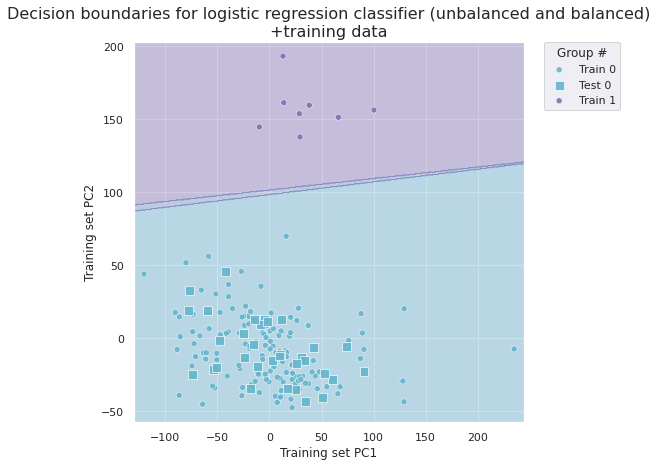

In [140]:
# Visualizing decision boundaries for the unbalanced and balanced LR models fit to training data:

class2num = dict(zip(classes,range(1,1+len(classes))))
cmap_classes = ListedColormap(['c','m'])

h=0.5
margin=10

## Defining a 2D mesh grid to compute model predictions:
x_min, x_max = X_train_pc[:, 0].min() - margin, X_train_pc[:, 0].max() + margin
y_min, y_max = X_train_pc[:, 1].min() - margin, X_train_pc[:, 1].max() + margin
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

## Predictions of unbalanced classifier:
Z = np.array([class2num[cls] for cls in LogRegClassif.predict(np.c_[xx.ravel(), yy.ravel()])])
Z = Z.reshape(xx.shape)

## Predictions of balanced classifier:
Z_bal = np.array([class2num[cls] for cls in LogRegClassif_bal.predict(np.c_[xx.ravel(), yy.ravel()])])
Z_bal = Z_bal.reshape(xx.shape)

## Contour map of predictions
fig,ax = plt.subplots(figsize=(7, 7))
plt.contourf(xx, yy, Z, cmap=cmap_classes, alpha=0.2)
plt.contourf(xx, yy, Z_bal, cmap=cmap_classes, alpha=0.2)

## Overlaying training/testing data (same colormap):

cdict = dict(zip(classes,['c','m']))

for cls in classes: 
  sns.scatterplot(x=X_train_pc[y_train==cls,0],y=X_train_pc[y_train==cls,1], c = [cdict[cls] for i in range(len(y_train[y_train==cls]))], label='Train '+str(cls),alpha=0.9)
  sns.scatterplot(x=X_test_pc[y_test==cls,0],y=X_test_pc[y_test==cls,1], c = [cdict[cls] for i in range(len(y_test[y_test==cls]))], label='Test '+str(cls),marker='s',s=80,alpha=0.9)

plt.xlabel('Training set PC1')
plt.ylabel('Training set PC2')
plt.legend(title='Group #',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title('Decision boundaries for logistic regression classifier (unbalanced and balanced)\n+training data',size=16)

plt.show()

---

### Model training with cross-validation (CV)

To learn robust and generalizable models, as well as tune model hyperparameters for improved performance, *CV* is applied to model training and evaluation (e.g. [James et al., 2021](https://www.statlearning.com/)) is applied to model training. Instead of a train/test split, the 'learning' set is further split into 'training' and  'tuning/validation' subsets, and the best performing model after training (least error on the validation set) is then applied on the held-out test set to provide a realistic estimate of classifier performance. The train/validation split within the learning set is repeated k times (k-fold CV) for each hyperparameter setting.


In the following, CV is illustrated with model evaluation as a function of the no. of PC dimensions. (This code snippet is an alternative to the CV implementations in sklearn.)

Note: The sklearn function [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#) is used to create the train + validate splits with same frequency distributions over the different classes represented in the dataset. Here we just use 2-fold cv due to the very small sample size for group 1.

**1) Cross-validation over no. of latent dimensions:**

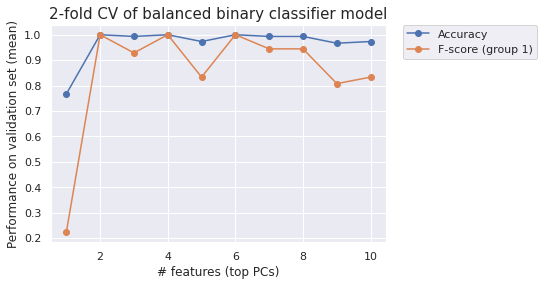

In [141]:
# @markdown Num of latent (PC space) dimensions to loop over in model training and cross-validation:
nMax =  10#@param range(20)

# Function for creating train/validation sets: 
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_train,y_train)

# For each fold/split, PCA is run on the training subset (here, denoted by 'tr' to distinguish it from the 'train' used earlier)
# and the validation set is projected into this PC space to avoid data leakage.

# Creating arrays to store CV accuracy and F-score values across CV-folds and hyperparam settings:
acc_mat,F_mat = [],[]

# Looping over k-folds:
for tr_index, val_index in skf.split(X_train, y_train):
  
  X_tr, X_val = X_train[tr_index], X_train[val_index]
  y_tr, y_val = y_train[tr_index], y_train[val_index]

  """
  ## Checking relative frequencies of classes among train/test sets:
  
  print('KFold Training set #:',len(y_tr))
  for c in classes: print(c,len(y_tr[y_tr == c]))

  print('KFold Validation set #:',len(y_val))
  for c in classes: print(c,len(y_val[y_val == c]))
  """

  ## Standardizing the training data matrix (zero mean, unit SD per feature/column)
  stdscaler = StandardScaler().fit(X_tr)
  X_tr_scaled = stdscaler.transform(X_tr)

  ## PCA on train data and projection into PC space:
  pca_tr = PCA(n_components=50).fit(X_tr_scaled)
  X_tr_pc = pca_tr.transform(X_tr_scaled)

  ## Projecting validation set on training set PC axes:

  X_val_scaled = stdscaler.transform(X_val)
  X_val_pc = pca_tr.transform(X_val_scaled)

  ## Looping over number of latent dimensions (# top PCs): 
  ## Training a binary balanced classifier on the 'tr' split, and evaluating accuracy + F-score for each trained model on the validation set

  fold_acc = []
  fold_F = []
  for n_comp in range(1,nMax+1):

    LogRegClassif = LogisticRegression(random_state=42,penalty='none', max_iter=1000, class_weight='balanced')
    LogRegClassif.fit(X_tr_pc[:,0:n_comp], y_tr)

    y_val_pred = LogRegClassif.predict(X_val_pc[:,0:n_comp])
    ClassAcc = LogRegClassif.score(X_val_pc[:,0:n_comp],y_val)
    F1 = f1_score(y_val,y_val_pred,average='binary')#,labels=classes)#'binary')
    fold_acc.append(ClassAcc)
    fold_F.append(F1)
    
    #print(n_comp,ClassAcc,F1)

  # Writing model performance metrics to array:
  acc_mat.append(fold_acc)
  F_mat.append(fold_F)

# Plotting mean accuracy and mean F-score (across folds) as functions of the model hyperparameter (nMax):

plt.plot(range(1,nMax+1),np.array(acc_mat).mean(axis=0),'o-',label='Accuracy')
plt.plot(range(1,nMax+1),np.array(F_mat).mean(axis=0),'o-',label='F-score (group 1)')

plt.xlabel('# features (top PCs)')
plt.ylabel('Performance on validation set (mean)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2-fold CV of balanced binary classifier model',size=15)

plt.show()


In this relatively simple example, the classifier model performance peaks at nMax >= 2.



**2) Cross-validation over L2 regularization strength:**

The CV can be equivalently repeated by considering another model hyperparamter, the *regularization strength*, which tunes the strength of the 'l2' penalty (default) in the log-reg model optimization. The parameter 'C' sets the inverse of the regularization strength, and is sampled over a wide range of magnitudes. Here the CV is done with a fixed number of PC dimensions (n_comp = 100).

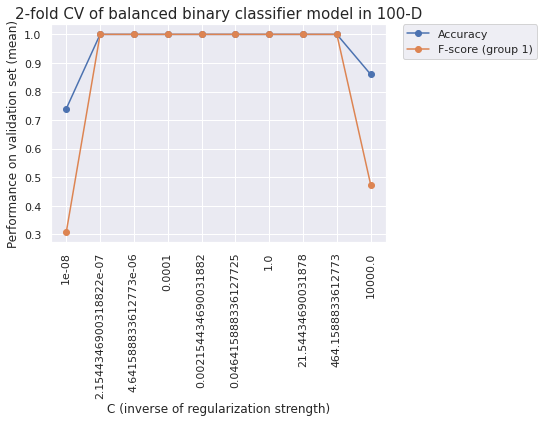

In [142]:
# Function for creating train/validation sets: 
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_train,y_train)

# For each fold/split, PCA is run on the training subset (here, denoted by 'tr' to distinguish it from the 'train' used earlier)
# and the validation set is projected into this PC space to avoid data leakage.

# Creating arrays to store CV accuracy and F-score values across CV-folds and hyperparam settings:
acc_mat,F_mat = [],[]

# Looping over k-folds:
for tr_index, val_index in skf.split(X_train, y_train):
  
  X_tr, X_val = X_train[tr_index], X_train[val_index]
  y_tr, y_val = y_train[tr_index], y_train[val_index]

  """
  ## Checking relative frequencies of classes among train/test sets:
  
  print('KFold Training set #:',len(y_tr))
  for c in classes: print(c,len(y_tr[y_tr == c]))

  print('KFold Validation set #:',len(y_val))
  for c in classes: print(c,len(y_val[y_val == c]))
  """

  ## Standardizing the training data matrix (zero mean, unit SD per feature/column)
  stdscaler = StandardScaler().fit(X_tr)
  X_tr_scaled = stdscaler.transform(X_tr)

  ## PCA on train data and projection into PC space:
  pca_tr = PCA(n_components=50).fit(X_tr_scaled)
  X_tr_pc = pca_tr.transform(X_tr_scaled)

  ## Projecting validation set on training set PC axes:

  X_val_scaled = stdscaler.transform(X_val)
  X_val_pc = pca_tr.transform(X_val_scaled)

  ## Looping over model hyperparameter (regularization C associated with l2 penalty): 
  ## Training a binary balanced classifier on the 'tr' split, and evaluating accuracy + F-score for each trained model on the validation set

  fold_acc = []
  fold_F = []

  n_comp = 100
  for C_reg in np.logspace(-8,4,10):

    LogRegClassif = LogisticRegression(random_state=42,penalty='l2',C=C_reg, max_iter=1000, class_weight='balanced')
    LogRegClassif.fit(X_tr_pc[:,0:n_comp], y_tr)

    y_val_pred = LogRegClassif.predict(X_val_pc[:,0:n_comp])
    ClassAcc = LogRegClassif.score(X_val_pc[:,0:n_comp],y_val)
    F1 = f1_score(y_val,y_val_pred,average='binary')#,labels=classes)#'binary')
    fold_acc.append(ClassAcc)
    fold_F.append(F1)
    
    #print(C_reg,ClassAcc,F1)

  # # Writing model performance metrics to array:
  acc_mat.append(fold_acc)
  F_mat.append(fold_F)


## Plotting mean accuracy and mean F-score (across folds) as functions of the tuned hyperparameter (C)

plt.plot(range(1,11),np.array(acc_mat).mean(axis=0),'o-',label='Accuracy')
plt.plot(range(1,11),np.array(F_mat).mean(axis=0),'o-',label='F-score (group 1)')

plt.xticks(range(1,11),[str(C) for C in np.logspace(-8,4,10)],rotation='vertical')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Performance on validation set (mean)')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2-fold CV of balanced binary classifier model in 100-D',size=15)

plt.show()

---

**In summary:**

- Downloaded global gene expression panel was explored to highlight groupings in terms of correlated gene expression profiles via dim reduction;

- Highlighted groups were associated with metadata identifiers for cancer subtypes

- A simple classifier was trained on a low-d (PC) representation of the data distribution to predict the group assignment (small or large group) based on the expression vector.

---